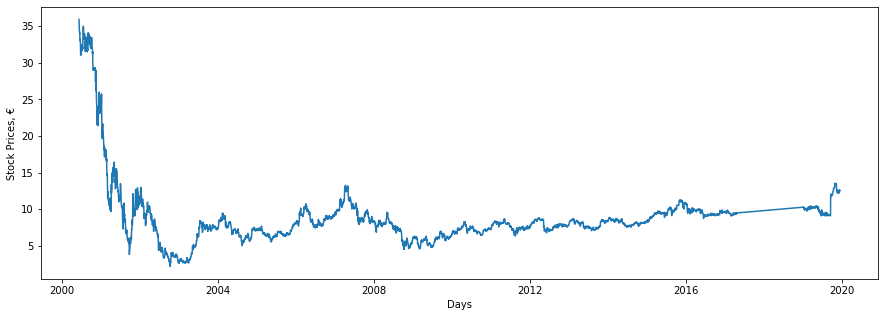

        Date  Close
0 2000-06-06  35.94
1 2000-06-07  35.20
2 2000-06-08  35.20
3 2000-06-09  34.52
4 2000-06-12  34.05
           Date  Close
4547 2019-12-10  12.32
4548 2019-12-11  12.64
4549 2019-12-12  12.42
4550 2019-12-13  12.50
4551 2019-12-16  12.60
[-0.02058987200890359, 0.0, -0.019318181818181807, -0.01361529548088082, -0.0014684287812040283, 0.0014705882352940341, -0.029368575624082235, 0.004538577912254333, -0.012048192771084508, -0.009146341463414549, -0.043076923076923034, 0.0006430868167202435, -0.000642673521850886, 0.001286173633440487, 0.0, -0.0012845215157353612, 0.04180064308681663, -0.006172839506172708, 0.009316770186335315, -0.013846153846153933, -0.0046801872074882555, -0.006269592476489006, 0.01388012618296534, 0.0, -0.007467330429371561, 0.03761755485893426, 0.015105740181268881, 0.02976190476190476, 0.011560693641618455, -0.00857142857142849, 0.0, -0.031700288184438076, -0.010416666666666708, 0.0006015037593985903, 0.0, 0.0, 0.006913134956417098, 0.0146268656

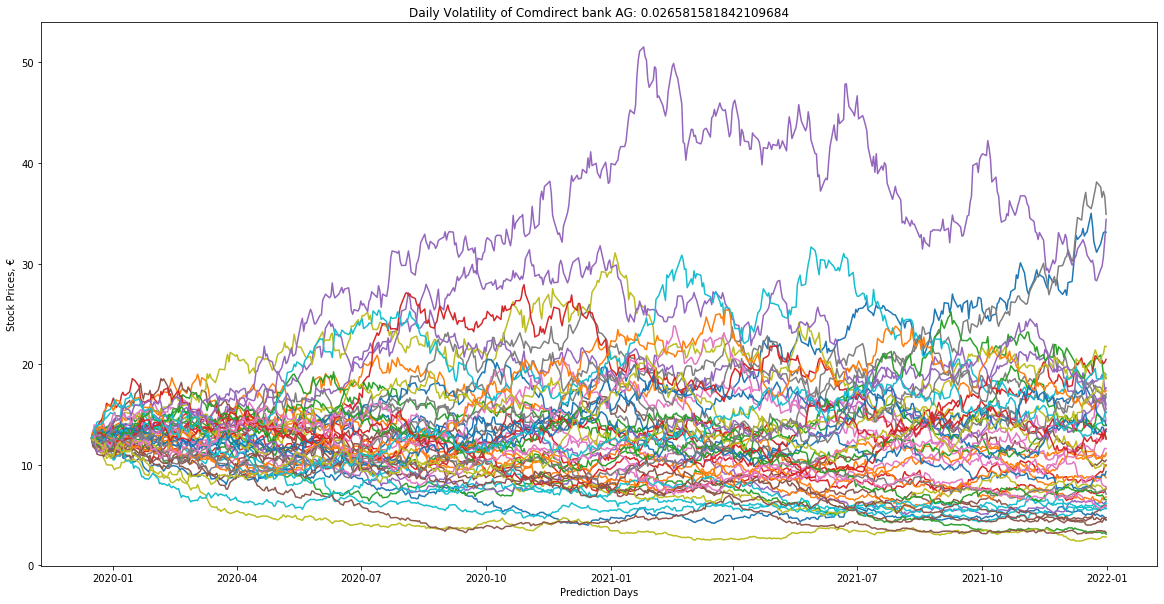

In [14]:
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

stock_name = 'FSE/COM_X'

# Plot of E.ON(a big scale energy company in Europe) 
#stock prices since beginning of 2019 (up to July)
prices = quandl.get(stock_name, 
                authtoken="KzmqS9W4TTQc2M5BatE_", 
                start_date = '2000-06-06', end_date = '2019-12-16'
                ).reset_index(drop = False)[['Date', 'Close']]
plt.figure(figsize = (15, 5))
plt.plot(prices['Date'], prices['Close'])
plt.xlabel('Days')
plt.ylabel('Stock Prices, €')
plt.show()

#--------------------------------------------------- GEOMETRIC BROWNIAN MOTION ------------------------------------------------

# Parameter Definitions

# So    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
# N     :   number of time points in prediction the time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns
# b     :   array for brownian increments
# W     :   array for brownian path

start_date = '2000-06-06'
end_date = '2019-12-16'
pred_end_date = '2021-12-31'

# We get daily closing stock prices of E.ON for July 2019
S_eon = quandl.get(stock_name, 
               authtoken="KzmqS9W4TTQc2M5BatE_", 
               start_date = start_date, end_date = end_date
               ).reset_index(drop = False)[['Date', 'Close']]
print(S_eon.head())
print(S_eon.tail())

returns = (S_eon.loc[1:, 'Close'] - \
           S_eon.shift(1).loc[1:, 'Close']) / \
           S_eon.shift(1).loc[1:, 'Close']
print(returns.tolist())

# Parameter Assignments
So = S_eon.loc[S_eon.shape[0]-1, "Close"]
dt = 1 # day   # User input
n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
                 format = "%Y-%m-%d") + pd.Timedelta('1 days'), 
                 end = pd.to_datetime(pred_end_date, 
                 format = "%Y-%m-%d")).to_series().map(lambda x: 
                 1 if x.isoweekday() in range(1,6) else 0).sum()
T = n_of_wkdays # days  # User input -> follows from pred_end_date
N = T / dt
t = np.arange(1, int(N) + 1)
mu = np.mean(returns)
sigma = np.std(returns)
scen_size = 50 # User input
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

# Calculating drift and diffusion components
drift = (mu - 0.5 * sigma**2) * t
print(drift)
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
print(diffusion)

# Making the predictions
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S)) # add So to the beginning series
print(S)

# Plotting the simulations
plt.figure(figsize = (20,10))
for i in range(scen_size):
    plt.title("Daily Volatility of Comdirect bank AG: " + str(sigma))
    plt.plot(pd.date_range(start = S_eon["Date"].max(), 
                end = pred_end_date, freq = 'D').map(lambda x:
                x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :])
    plt.ylabel('Stock Prices, €')
    plt.xlabel('Prediction Days')
plt.show()

# Dataframe format for predictions - first 10 scenarios only
Preds_df = pd.DataFrame(S.swapaxes(0, 1)[:, :10]).set_index(
           pd.date_range(start = S_eon["Date"].max(), 
           end = pred_end_date, freq = 'D').map(lambda x:
           x if x.isoweekday() in range(1, 6) else np.nan).dropna()
           ).reset_index(drop = False)